In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

df = pd.read_csv("classification_data_raw.csv")

# --- Step 1: Set features and target ---
features = [
    'income', 'per_college_educated_x', 'per_college_educated_y', 
    'per_low_income', 'percent_nonwhite', 'region_nonwhite', 'gentrified_rent'
]

# Split train and test by year
train_df = df[df['year'].between(2012, 2022)]
test_df = df[df['year'] == 2023]

X_train = train_df[features]
y_train = train_df['gentrified']
X_test = test_df[features]
y_test = test_df['gentrified']

# --- Step 2: Scale features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Step 3: Train Random Forest ---
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# --- Step 4: Predict on 2023 data ---
test_df['predicted_prob'] = model.predict_proba(X_test_scaled)[:, 1]
test_df['predicted_class'] = model.predict(X_test_scaled)

print("📊 Classification Report for 2023:")
print(classification_report(y_test, test_df['predicted_class']))
print(test_df[['zip_code', 'year', 'gentrified', 'predicted_class', 'predicted_prob']].head())

# --- Step 5: Predict feature values for 2030 ---

# Assumption: You want to predict each feature for 2030 based on trends
# A simple way: fit regression models on each feature vs year per zip_code and predict 2030

from sklearn.linear_model import LinearRegression

def predict_feature_2030(df, feature):
    pred_list = []
    for zip_code in df['zip_code'].unique():
        temp = df[df['zip_code'] == zip_code]
        if len(temp) < 3:  # not enough data points
            # fallback to last known value
            pred_val = temp[feature].iloc[-1]
        else:
            # Fit linear regression of feature vs year
            lr = LinearRegression()
            lr.fit(temp['year'].values.reshape(-1, 1), temp[feature].values)
            pred_val = lr.predict(np.array([[2030]]))[0]
        pred_list.append({'zip_code': zip_code, feature: pred_val})
    return pd.DataFrame(pred_list)

# Create a DataFrame with 2030 feature predictions for all features
feature_preds_2030 = pd.DataFrame({'zip_code': df['zip_code'].unique()})

for feature in features:
    pred_df = predict_feature_2030(train_df, feature)
    feature_preds_2030 = feature_preds_2030.merge(pred_df, on='zip_code')

# --- Step 6: Scale 2030 predicted features ---
X_2030_scaled = scaler.transform(feature_preds_2030[features])

# --- Step 7: Predict gentrification probability for 2035 ---
# Assuming 2035 features are same as 2030 features (or you can extrapolate similarly)
# Here, just reuse 2030 scaled features (for example)

predicted_probs_2035 = model.predict_proba(X_2030_scaled)[:, 1]
predicted_class_2035 = model.predict(X_2030_scaled)

feature_preds_2030['predicted_gentrified_prob_2035'] = predicted_probs_2035
feature_preds_2030['predicted_gentrified_class_2035'] = predicted_class_2035

print("Predicted gentrification probability in 2035:")
print(feature_preds_2030[['zip_code', 'predicted_gentrified_prob_2035', 'predicted_gentrified_class_2035']].head())


/var/folders/mx/cv_f44qs0m57p0lzjb0p91kh0000gn/T/ipykernel_3169/188050078.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_prob'] = model.predict_proba(X_test_scaled)[:, 1]
/var/folders/mx/cv_f44qs0m57p0lzjb0p91kh0000gn/T/ipykernel_3169/188050078.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_class'] = model.predict(X_test_scaled)


📊 Classification Report for 2023:
              precision    recall  f1-score   support

       False       0.99      0.99      0.99     15837
        True       0.76      0.78      0.77       518

    accuracy                           0.99     16355
   macro avg       0.88      0.88      0.88     16355
weighted avg       0.99      0.99      0.99     16355

        zip_code  year  gentrified  predicted_class  predicted_prob
183055       602  2023       False            False            0.00
183056       603  2023       False            False            0.02
183057       610  2023       False            False            0.00
183058       631  2023       False            False            0.01
183059       662  2023       False            False            0.00
Predicted gentrification probability in 2035:
   zip_code  predicted_gentrified_prob_2035  predicted_gentrified_class_2035
0       602                            0.00                            False
1       603                    

ROC AUC Score: 0.7747


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


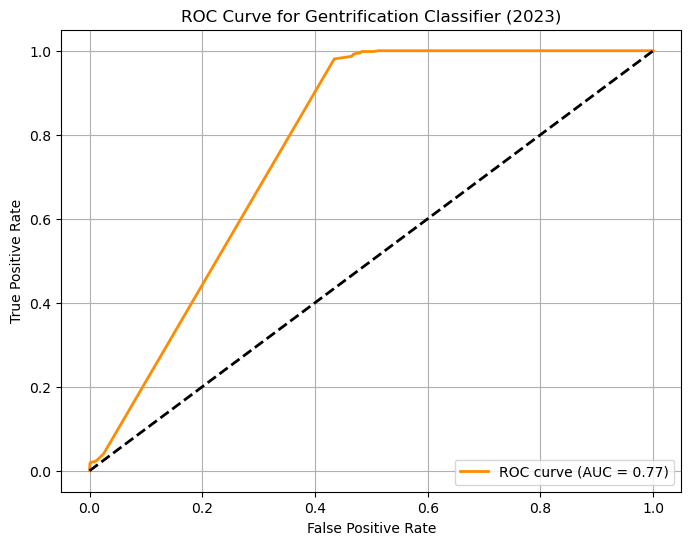

In [2]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

# y_test: true labels
# y_proba: predicted probabilities from the model

# Step 1: Get predicted probabilities for the positive class (gentrified = True)
y_proba = model.predict_proba(X_test)[:, 1]  # probability for class 'True'

# Step 2: Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Step 3: Calculate AUC
roc_auc = auc(fpr, tpr)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Step 4: Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Gentrification Classifier (2023)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


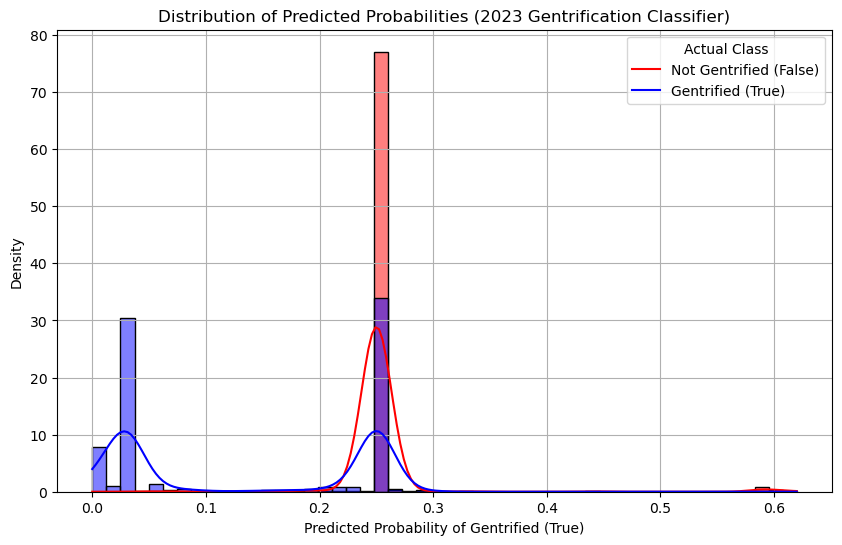

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get predicted probabilities for the positive class (gentrified = True)
y_proba = model.predict_proba(X_test)[:, 1]

# Create a DataFrame to pair probabilities with true labels
import pandas as pd
df_probs = pd.DataFrame({
    'probability': y_proba,
    'actual': y_test
})

# Plot distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df_probs, x='probability', hue='actual', bins=50, kde=True, palette={False: 'blue', True: 'red'}, stat="density", common_norm=False)
plt.title("Distribution of Predicted Probabilities (2023 Gentrification Classifier)")
plt.xlabel("Predicted Probability of Gentrified (True)")
plt.ylabel("Density")
plt.legend(title='Actual Class', labels=['Not Gentrified (False)', 'Gentrified (True)'])
plt.grid(True)
plt.show()


In [5]:
import joblib

joblib.dump(model, 'random_forest.pkl')

['random_forest.pkl']